In [1]:
import cv2
import numpy as np
import roypy
import matplotlib.pyplot as plt
import argparse
import time
import queue
import math
import random
import matplotlib

import tracking
import touched_detection
from PIL import Image, ImageDraw
from sample_camera_info import print_camera_info
from roypy_sample_utils import CameraOpener, add_camera_opener_options

# 調整np.array輸出格式
np.set_printoptions(suppress=True)

# Image Streamer

In [2]:
class MyListener(roypy.IDepthDataListener):

    def __init__(self, z_queue, gray_queue, points3D_queue, ConfidenceIndex_queue, Confidence_queue, undistortImage=False):
        super(MyListener, self).__init__()
        self.z_queue = z_queue
        self.gray_queue = gray_queue
        self.points3D_queue = points3D_queue
        self.ConfidenceIndex_queue = ConfidenceIndex_queue
        self.Confidence_queue = Confidence_queue
        self.undistortImage = undistortImage
        self.cameraMatrix = None
        self.distortionCoefficients = None

    def onNewData(self, data):
        zvalues = []
        xvalues = []
        yvalues = []
        grayvalues = []
        points3D = []
        ConfidenceIndexvalues = [] # whether the pixel measured a valid 3D value
        Confidencevalue = []
        for i in range(data.getNumPoints()):
            zvalues.append(data.getZ(i))
            xvalues.append(data.getX(i))
            yvalues.append(data.getY(i))
            grayvalues.append(data.getGrayValue(i))
            
            Confidencevalue.append(data.getDepthConfidence(i))
            if data.getDepthConfidence(i) > 0:
                ConfidenceIndexvalues.append(i)
            
        zarray = np.asarray(zvalues)
        z = zarray.reshape (-1, data.width)        
        self.z_queue.put(z)
        
        xarray = np.asarray(xvalues)
        x = xarray.reshape (-1, data.width)
        
        yarray = np.asarray(yvalues)
        y = yarray.reshape (-1, data.width)
        
        points3D = np.dstack((x,y,z))
        self.points3D_queue.put(points3D)
        
        
        grayarray = np.asarray(grayvalues)
        q = grayarray.reshape (-1, data.width)        
        self.gray_queue.put(q)
        
        Confidencearray = np.asarray(Confidencevalue)
        Confidence = Confidencearray.reshape (-1, data.width)
        self.Confidence_queue.put(Confidence)
        #ConfidenceIndex_queue
        ConfidenceIndex = np.asarray(ConfidenceIndexvalues)
        self.ConfidenceIndex_queue.put(ConfidenceIndex)

    def paint(self, data, name, isGray = False, cv2_show = False):
        """
        Called in the main thread, with data containing one of the items that was added to the queue in onNewData
        :param data:
        :return:
        """
        if cv2_show == True: 
            cv2.imshow(name, data)
        else:
            # create a figure and show the raw data
            plt.figure(1)
            if isGray == False:
                plt.imshow(data),plt.title(name),plt.axis('off')
            else: 
                plt.imshow(data,plt.cm.gray),plt.title(name),plt.axis('off')

            plt.show(block=False)
            plt.draw()

            # this pause is needed to ensure the drawing for some backends
            plt.pause(0.001)

# Tracker Engine

In [3]:
def process_event(z_queue, gray_queue, points3D_queue, ConfidenceIndex_queue, Confidence_queue, painter=None, seconds=150):
    First = True
    timeout = .5
    wait_data_flag = False
    capture_frame = 5
    frame = 0
    t_end = time.time() + seconds # create a loop that will rsecondsthe given amount of time
    start_time = time.time()
    receive_time = 1
    while time.time() < t_end:
        # Press Q on keyboard to exit 
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
        try:
            # try to retrieve an item from the queue
            # this will block until an item can be retrieved
            # or the timeout of 1 second is hit
            zImage = z_queue.get(wait_data_flag, timeout) if z_queue else None
            grayImage_int32 = gray_queue.get(wait_data_flag, timeout) if gray_queue else None
            points3D = points3D_queue.get(wait_data_flag, timeout) if points3D_queue else None
            ConfidenceIndex = ConfidenceIndex_queue.get(wait_data_flag, timeout) if ConfidenceIndex_queue else None
            Confidence = Confidence_queue.get(wait_data_flag, timeout) if Confidence_queue else None
        except queue.Empty:
            # this will be thrown when the timeout is hit
            continue
        else:
            frame = frame + 1
            if (frame > capture_frame):
                # estimated time
                receive_time = (time.time() - start_time)
                frame = 0
                start_time = time.time()
            if(receive_time != 0):
                size = zImage.shape
                cv2.putText(img=zImage, text=('fps=%.1f'%(5/receive_time)), org=(0, size[1]-75), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.25, color=(255,255,255))
            cv2.imshow('zImage', zImage)
            
            if First == True:
                #RANSAM to get surface plane
                surface_plane, depthImg, plane_mask = RANSAM(points3D, ConfidenceIndex, ransac_iteration = 500, inliner_threshold = 0.01)
                First = False
                print("firstly RANSAM")
            else:
                #
                s_time = time.time()
                depthImg = get_depth_map(points3D, surface_plane)
                print('depth: %.4f'%(time.time() - s_time))
                
                #Canny edge map(infrared image) + threshold based edge map(depth image)
                s_time = time.time()
                Cannyedges, Threshold_based_edge, Edge_map, grayImage = get_edge_map(grayImage_int32, depthImg)
                print('get edge map: %.4f s'%(time.time() - s_time))
                
                #Get hight region by Hight and record its position
                s_time = time.time()
                High_region_Image, high_region_list = get_high_region(depthImg)
                print('get hight region: %.4f s'%(time.time() - s_time))
                
                #Get Hand mask by Flood fill from high region position with Edge map
                s_time = time.time()
                Hand_mask_Image = get_Hand_mask(Edge_map, high_region_list, High_region_Image)
                print('get hand mask: %.4f s'%(time.time() - s_time))
                
                #
                s_time = time.time()
                cnt, contours_image, hand_center, fingertips = find_fingertip(Hand_mask_Image,True)
                print('find fingertip: %.4f s'%(time.time() - s_time))
                
                # tracking user hand and fingertips
                s_time = time.time()
                hands_hand, fingertips_pos, tracking_iamge = tracking.hand_tracking(hand_center, fingertips, points3D, contours_image)
                print('hand tracking: %.4f s'%(time.time() - s_time))
                
                # detecte fingers whenther touching the surface
                s_time = time.time()
                touched_flag, touching_detection_image = touched_detection.touching_detection(fingertips_pos, Hand_mask_Image, depthImg, contours_image)
                print('touched detection: %.4f s'%(time.time() - s_time))
                
                #Show original image and result image
#                 painter.paint(grayImage_int32,'Gray Image',True)
#                 painter.paint(depthImg,'Depth')
#                 painter.paint(Cannyedges,'Canny Edges',True)
#                 painter.paint(Threshold_based_edge,'Threshold_based Edge',True)
#                 painter.paint(Edge_map,'Edge map',True)
#                 painter.paint(High_region_Image,'High region Image',True)
#                 painter.paint(Hand_mask_Image,'Hand mask Image')
#                 painter.paint(contours_image,'Contours Image',True)
                painter.paint(tracking_iamge,'tracking Image',False, True)
                painter.paint(touching_detection_image,'touched Image', False, True)
            
#             #Store Image
#             IsStore = False
#             if IsStore == True:
#                 matplotlib.image.imsave('zImage.png', zImage)
#                 matplotlib.image.imsave('grayImage_int32.png', grayImage_int32)
#                 matplotlib.image.imsave('points3D.png', points3D)
#                 matplotlib.image.imsave('Confidence.png', Confidence)

            

## RANSAM

In [4]:
def Dis_pt2plane(pts, a, b, c, d):
    """
    Compute the distance from points to the plane
    """
    normal = math.sqrt(a*a+b*b+c*c)
    if normal == 0:
        normal = 1
    
    v = np.array([a,b,c])
    dis = abs(np.dot(pts,v.T)+d)/normal
    return dis

def get_Plane(sampts):
    """
    Compute the equation of the plane
    """
    p1 = sampts[0]
    p2 = sampts[1]
    p3 = sampts[2]
    
    a = ( (p2[1]-p1[1])*(p3[2]-p1[2])-(p2[2]-p1[2])*(p3[1]-p1[1]) )
    b = ( (p2[2]-p1[2])*(p3[0]-p1[0])-(p2[0]-p1[0])*(p3[2]-p1[2]) )
    c = ( (p2[0]-p1[0])*(p3[1]-p1[1])-(p2[1]-p1[1])*(p3[0]-p1[0]) )
    d = ( 0-(a*p1[0]+b*p1[1]+c*p1[2]) )
    
    return a,b,c,d

def Random3points(points3D, ConfidenceIndex):
    """
    Random choose 3 Confidence points
    """
    sample_number = 3
    sample_point_index = random.sample(range(ConfidenceIndex.shape[0]), sample_number)
    sample_points = np.zeros((sample_number,3))
    for i in range(sample_number):
        Confidence_point_index = sample_point_index[i]
        index = ConfidenceIndex[Confidence_point_index]
        y = index // points3D.shape[1]
        x = index % points3D.shape[1]
        sample_points[i] = points3D[y][x]
    return sample_points

# def Random3points(points3D):
#     sample_number = 3
#     sample_point_index = random.sample(range(points3D.shape[0]*points3D.shape[1]), sample_number)
#     sample_points = np.zeros((sample_number,3))
#     for i in range(sample_number):
#         index = sample_point_index[i]
#         y = index // points3D.shape[1]
#         x = index % points3D.shape[1]
#         sample_points[i] = points3D[y][x]
#     return sample_points

def get_inliner_num(points3D,a,b,c,d,inliner_threshold):
    """
    Compute the liner points which distance to plane < threshold
    Also get distance from points to the plane (new Depth Image which re-project depth pixels in surface plane)
    """
    inliner_num = 0
    
    dist = Dis_pt2plane(points3D,a,b,c,d)
    inliner_mask = dist < inliner_threshold
    inliner_num = np.sum(inliner_mask)
    return inliner_num, inliner_mask, dist

def RANSAM(points3D, ConfidenceIndex, ransac_iteration = 1000, inliner_threshold = 0.01):
    best_inlinernum = -1
    best_inlinernum = 0
    best_plane = np.zeros((1,4))
    best_depthImage = np.zeros((points3D.shape[0],points3D.shape[1]))
    best_plane_mask = np.zeros((points3D.shape[0],points3D.shape[1]))
#     best_sampts = np.zeros((3,3))
    
#     print(points3D.shape,points3D[80:90,110])
    for i in range(ransac_iteration):
        sampts = Random3points(points3D, ConfidenceIndex)
        a,b,c,d = get_Plane(sampts)
        
        inliner_num, inliner_mask, depthImage = get_inliner_num(points3D,a,b,c,d,inliner_threshold)
        if(inliner_num > best_inlinernum):
            best_inlinernum = inliner_num
            best_plane = np.array([a,b,c,d])
            best_plane_mask = inliner_mask
            best_depthImage = depthImage
#             best_sampts = sampts
            
    print("Inliner Number\n", best_inlinernum)
    print("Inliner plane\n", best_plane)
    return best_plane, best_depthImage, best_plane_mask

# ptset = np.array(([0, 0, 0],
#             [1, 2, 0],
#             [2, 2, 0]))
# a,b,c,d = get_Plane(ptset)
# pts = np.zeros((2,2,3))
# pts[0,0] = np.array([0, 0, 1])
# pts[0,1] = np.array([0, 0, 2])
# pts[1,0] = np.array([0, 0, 3])
# pts[1,1] = np.array([0, 0, 4])
# z = Dis_pt2plane(pts,a,b,c,d)
# print(z,z.shape)
# get_inliner_num(pts,a,b,c,d,7)

## Depth Map

In [5]:
def get_depth_map(points3D,plane):
    """
    Compute the liner points which distance to plane < threshold
    Also get distance from points to the plane (new Depth Image which re-project depth pixels in surface plane)
    """
    dist = Dis_pt2plane(points3D,plane[0],plane[1],plane[2],plane[3])
    return dist

# Edge map

In [6]:
def get_edge_map(grayImage,depthImage):
    """
    Canny Edge map
    turn grayImg from int32 to int8
    blur the grayImg then do Canny Edge
    """
    low_threshold = 1
    high_threshold = 8
    grayimg_int8 = cv2.convertScaleAbs(grayImage, alpha=(255.0/65535.0))
    
    kernel_size = 3
    blur_gray = cv2.GaussianBlur(grayimg_int8,(kernel_size, kernel_size), 0)
    Cannyedges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    """
    Threshold based Edge map
    if depth between the pixel and its nearby pixels > near_depth_threshold, then labeled it
    """
    s_time = time.time()
    near_depth_threshold = 0.05
    Threshold_based_edge = np.zeros((depthImage.shape[0],depthImage.shape[1]))
#     for y in range(1,depthImage.shape[0]-1):
#         for x in range(1,depthImage.shape[1]-1):
#             center = depthImage[y, x]
#             if(((center - depthImage[y-1,x-1]) > near_depth_threshold) or ((center - depthImage[y-1,x-1]) < -near_depth_threshold)):
#                 Threshold_based_edge[y,x] = True
#                 continue
#             if(((center - depthImage[y-1,x]) > near_depth_threshold) or ((center - depthImage[y-1,x]) < -near_depth_threshold)) :
#                 Threshold_based_edge[y,x] = True
#                 continue
#             if(((center - depthImage[y-1,x+1]) > near_depth_threshold) or ((center - depthImage[y-1,x+1]) < -near_depth_threshold)):
#                 Threshold_based_edge[y,x] = True
#                 continue
#             if(((center - depthImage[y,x-1]) > near_depth_threshold) or ((center - depthImage[y,x-1]) < -near_depth_threshold)):
#                 Threshold_based_edge[y,x] = True
#                 continue
#             if(((center - depthImage[y,x+1]) > near_depth_threshold) or ((center - depthImage[y,x+1]) < -near_depth_threshold)):
#                 Threshold_based_edge[y,x] = True
#                 continue
#             if(((center - depthImage[y+1,x-1]) > near_depth_threshold) or ((center - depthImage[y+1,x-1]) < -near_depth_threshold)):
#                 Threshold_based_edge[y,x] = True
#                 continue
#             if(((center - depthImage[y+1,x]) > near_depth_threshold) or ((center - depthImage[y+1,x]) < -near_depth_threshold)):
#                 Threshold_based_edge[y,x] = True
#                 continue
#             if(((center - depthImage[y+1,x+1]) > near_depth_threshold) or ((center - depthImage[y+1,x+1]) < -near_depth_threshold)):
#                 Threshold_based_edge[y,x] = True
#                 continue
    
    h = depthImage.shape[0]
    w = depthImage.shape[1]
    depth_img_transform = np.zeros((h+1,w+1))
    depth_img_transform[:h,:w] = depthImage
    #check left up depth threshold
    depth_img_transform[1:h+1,1:w+1] = depthImage
    check_depth_threshold = abs(depthImage - depth_img_transform[:h,:w]) > near_depth_threshold
    Threshold_based_edge = np.logical_or(Threshold_based_edge, check_depth_threshold)
    #check up depth threshold
    depth_img_transform[:h,:w] = depthImage
    depth_img_transform[1:h+1,:w] = depthImage
    check_depth_threshold = abs(depthImage - depth_img_transform[:depthImage.shape[0],:depthImage.shape[1]]) > near_depth_threshold
    Threshold_based_edge = np.logical_or(Threshold_based_edge, check_depth_threshold)
    #check Right up depth threshold
    depth_img_transform[:h,:w] = depthImage
    depth_img_transform[1:h+1,:w-1] = depthImage[:,1:w]
    check_depth_threshold = abs(depthImage - depth_img_transform[:h,:w]) > near_depth_threshold
    Threshold_based_edge = np.logical_or(Threshold_based_edge, check_depth_threshold)
    #check Left depth threshold
    depth_img_transform[:h,:w] = depthImage
    depth_img_transform[:h,1:w+1] = depthImage
    check_depth_threshold = abs(depthImage - depth_img_transform[:h,:w]) > near_depth_threshold
    Threshold_based_edge = np.logical_or(Threshold_based_edge, check_depth_threshold)
    #check Right depth threshold
    depth_img_transform[:h,:w] = depthImage
    depth_img_transform[:h,:w-1] = depthImage[:,1:w]
    check_depth_threshold = abs(depthImage - depth_img_transform[:h,:w]) > near_depth_threshold
    Threshold_based_edge = np.logical_or(Threshold_based_edge, check_depth_threshold)
    #check Left down depth threshold
    depth_img_transform[:h,:w] = depthImage
    depth_img_transform[:h-1,1:w+1] = depthImage[1:h,:]
    check_depth_threshold = abs(depthImage - depth_img_transform[:h,:w]) > near_depth_threshold
    Threshold_based_edge = np.logical_or(Threshold_based_edge, check_depth_threshold)
    #check down depth threshold
    depth_img_transform[:h,:w] = depthImage
    depth_img_transform[:h-1,:w] = depthImage[1:h,:]
    check_depth_threshold = abs(depthImage - depth_img_transform[:h,:w]) > near_depth_threshold
    Threshold_based_edge = np.logical_or(Threshold_based_edge, check_depth_threshold)
    #check Right down depth threshold
    depth_img_transform[:h,:w] = depthImage
    depth_img_transform[:h-1,:w-1] = depthImage[1:h,1:w]
    check_depth_threshold = abs(depthImage - depth_img_transform[:h,:w]) > near_depth_threshold
    Threshold_based_edge = np.logical_or(Threshold_based_edge, check_depth_threshold)
    
    
    print('*get threshold edge: %.4f s'%(time.time()-s_time))
    """
    Merge Canny Edge map and Threshold based Edge map
    """
    Edge_map = np.logical_or(Cannyedges,Threshold_based_edge)
    
    return Cannyedges,Threshold_based_edge, Cannyedges, blur_gray

# Find High Region

In [7]:
def get_high_region(depthImage):
    """
    Define plane edge
    High region : > 0.04 
    ==> Flood fill mask : if pixels value > 0.04, then its value of mask image = 0 
    ==> mask = depthImage < 0.04
    
    Next, reject the region which dose not connet with plane edge and record its position
    ==>Just do Flood fill around the plane edge
    """
    h, w = depthImage.shape[:2]
    high_region_mask = np.ones((h+2,w+2), np.uint8)
    high_region_mask[1:h+1,1:w+1] = depthImage < 0.04 # > 0.04 False == 0, Flood fill will fill pixels with 0
    resultImg = np.zeros((h,w), np.uint8)
    
    #define plane edge
    plane_edge = 25
    
    x1 = plane_edge
    x2 = w - plane_edge
    y1 = plane_edge
    y2 = h - plane_edge
    
    high_list = []
    
    for y in range(plane_edge, y2):
        if high_region_mask[y+1,x1+1] == 0 and resultImg[y,x1] != True:
            cv2.floodFill(resultImg, high_region_mask, (x1, y),True, cv2.FLOODFILL_MASK_ONLY)
            high_list.append((x1,y))
            
        if high_region_mask[y+1,x2+1] == 0 and resultImg[y,x2] != True:
            cv2.floodFill(resultImg, high_region_mask, (x2, y),True, cv2.FLOODFILL_MASK_ONLY)
            high_list.append((x2,y))
            
    for x in range(plane_edge, x2):
        if high_region_mask[y1+1,x+1] == 0 and resultImg[y1,x] != True:
            cv2.floodFill(resultImg, high_region_mask, (x, y1),True, cv2.FLOODFILL_MASK_ONLY)
            high_list.append((x, y1))
            
        if high_region_mask[y2+1,x+1] == 0 and resultImg[y2,x] != True:
            cv2.floodFill(resultImg, high_region_mask, (x, y2),True, cv2.FLOODFILL_MASK_ONLY)
            high_list.append((x, y2))
    
    return resultImg, high_list

## Hand Mask

In [8]:
def get_Hand_mask(Edge_map, high_list, High_region_Image):
    """
    Flood fill from high region position and stop when reach edge
    Only fill in the hight region mask 
    ==> Prevent flood fill from seed which filled region does not the hight region
    """
    h, w = Edge_map.shape[:2]
    
    resultImg = Edge_map.copy()
    resultImg.dtype = 'uint8'
    mask = np.zeros((h+2,w+2), np.uint8)
    mask1 = np.ones((h+2,w+2), np.uint8)
    mask1[1:h+1,1:w+1] = High_region_Image == False

    for i in range(len(high_list)):
        cv2.floodFill(resultImg, mask1, high_list[i],True,cv2.FLOODFILL_FIXED_RANGE)
    
    resultImg = resultImg - Edge_map
    
    return resultImg

## Find Fingertip

In [9]:
def find_fingertip(hand_mask, debug = False):
    '''
        return: 
        @cnt: contours
    '''
    fingertips = []
    kernel_size = 7
    
    #Smooth the mask and find the contours
    smooth_mask = cv2.GaussianBlur(hand_mask,(kernel_size, kernel_size), 0)
    (_, cnts, _) = cv2.findContours(smooth_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #convert the result image into RGB image
    contours_image = cv2.convertScaleAbs(smooth_mask, alpha=(255))
    contours_image = cv2.cvtColor(contours_image, cv2.COLOR_GRAY2BGR)
    
    # Find the contour with max area
    maxArea = 0
    hull = None
    for i in range(len(cnts)):
        area = cv2.contourArea(cnts[i])
        if area > maxArea:
            maxArea = area
            hull = cv2.convexHull(cnts[i])
            Contours = cnts[i]
    
    cx, cy = (0,0)
    if hull is not None : 
        # get centroid from hand, then Draw the center and Hull_Convex
        M = cv2.moments(hull)
        cx = int(M["m10"]/M["m00"])
        cy = int(M["m01"]/M["m00"])
        if(debug == True):
            cv2.circle(contours_image, (cx, cy), 5, (0,0,255), 3)
        cv2.drawContours(contours_image, [Contours], -1, (255,0,0), 2)
        
        #Find the Fingertips
        fingertips, contours_image = find_fingertips_by_dot(Contours, hull, contours_image, debug)

    return cnts, contours_image, (cx, cy), np.asarray(fingertips, dtype=np.int32)


def find_fingertips_by_dot(Contours, hull, contours_image, debug=False):
    fingertips = []
    skip = 2
    Convex = (0,0)
    threshold = 10
    first = True
    for i in range(skip, len(Contours)-skip):
        p = Contours[i-skip]
        q = Contours[i]
        r = Contours[i+skip]

        dot = np.dot(q-p,(r-p).T)
        if (dot < 20 or dot > -20):
            points = (p[0,0],p[0,1])
            if first == True:
                Convex = points
                first = False
            IsnotEdge = points[0]!=0 and points[1]!=0 and points[0]!=contours_image.shape[1] and points[1]!=contours_image.shape[0]
            IsConvex = Points_is_convex(hull, points, threshold)
            Labeled = abs(Convex[0] - points[0]) > threshold and abs(Convex[1] - points[1]) > threshold
            #if the point is in the convex list and haven't be labeled, then add it to Fingertip list
            if IsConvex and Labeled and IsnotEdge:
                Convex = points
                fingertips.append(Convex)
                if(debug==True):
                    cv2.circle(contours_image, Convex, 5 , (0,255,0) , 3)
    return fingertips, contours_image

## Cotour Map

In [10]:
def Points_is_convex_all(hull, points, threshold):
    label = False
    label_hull = hull.copy()
    for i in range(len(hull)):
        if abs(hull[i,0,0] - points[0]) <= threshold and abs(hull[i,0,1] - points[1]) <= threshold:
            label_hull[i,0] = (-1, -1)
            label = True
    return label, label_hull

def Points_is_convex(hull, points, threshold):
    label = False
    label_hull = hull.copy()
    for i in range(len(hull)):
        if abs(hull[i,0,0] - points[0]) <= threshold and abs(hull[i,0,1] - points[1]) <= threshold:
            label_hull[i,0] = (-1, -1)
            label = True
            return label
    return label

In [11]:
# sample_open_cv()

In [12]:
##True: white 1  False: black 0
# ptset = np.array(([False, False, False],
#             [True, True, False],
#             [False, True, False]))
# plt.imshow(ptset,plt.cm.gray)

# Main

In [13]:
def main ():
    parser = argparse.ArgumentParser(usage=__doc__)
    add_camera_opener_options(parser)
    parser.add_argument("--seconds", type=int, default=15, help="duration to capture data")
    options = parser.parse_args(args=['--rrf','456.rrf','--seconds', '5'])
#     options = parser.parse_args(args=['--seconds', '5'])
    opener = CameraOpener(options)
    cam = opener.open_camera()

    print_camera_info (cam)
    print("isConnected", cam.isConnected())
    print("getFrameRate", cam.getFrameRate())
    print(cam.getFilterLevel())

    z_queue = queue.Queue()
    gray_queue = queue.Queue()
    points3D_queue = queue.Queue()
    ConfidenceIndex_queue = queue.Queue()
    Confidence_queue = queue.Queue()
    l = MyListener(z_queue,gray_queue,points3D_queue,ConfidenceIndex_queue,Confidence_queue)

    cam.registerDataListener(l)
    cam.startCapture()

    process_event(z_queue, gray_queue, points3D_queue, ConfidenceIndex_queue, Confidence_queue, painter=l, seconds=15)

    cam.stopCapture()
    cv2.destroyAllWindows()
    
if (__name__ == "__main__"):
    import profile
    
    profile.run('main()')

Filename: 456.rrf
        Camera information
Type:            PICOFLEXX
Width:           224
Height:          171
Operation modes: 1
    MODE_PLAYBACK
        this operation mode has 556728576 streams
CameraInfo items: 0
isConnected True
getFrameRate 0
200
Inliner Number
 35017
Inliner plane
 [ 0.00030872  0.00068837 -0.01315867  0.00273187]
firstly RANSAM
depth: 0.0020
*get threshold edge: 0.0070 s
get edge map: 0.0100 s
get hight region: 0.0010 s
get hand mask: 0.0010 s
find fingertip: 0.0010 s
hand tracking: 0.0000 s
touched detection: 0.0010 s
depth: 0.0020
*get threshold edge: 0.0020 s
get edge map: 0.0040 s
get hight region: 0.0010 s
get hand mask: 0.0000 s
find fingertip: 0.0010 s
hand tracking: 0.0000 s
touched detection: 0.0000 s
depth: 0.0010
*get threshold edge: 0.0060 s
get edge map: 0.0080 s
get hight region: 0.0010 s
get hand mask: 0.0010 s
find fingertip: 0.0010 s
hand tracking: 0.0010 s
touched detection: 0.0010 s
depth: 0.0020
*get threshold edge: 0.0060 s
get edge map

depth: 0.0010
*get threshold edge: 0.0020 s
get edge map: 0.0030 s
get hight region: 0.0020 s
get hand mask: 0.0010 s
find fingertip: 0.0090 s
hand tracking: 0.0010 s
touched detection: 0.0010 s
depth: 0.0010
*get threshold edge: 0.0020 s
get edge map: 0.0030 s
get hight region: 0.0010 s
get hand mask: 0.0000 s
find fingertip: 0.0010 s
hand tracking: 0.0010 s
touched detection: 0.0000 s
depth: 0.0030
*get threshold edge: 0.0050 s
get edge map: 0.0050 s
get hight region: 0.0010 s
get hand mask: 0.0010 s
find fingertip: 0.0678 s
hand tracking: 0.0010 s
touched pos: (127, 83)
touched detection: 0.0030 s
depth: 0.0020
*get threshold edge: 0.0060 s
get edge map: 0.0070 s
get hight region: 0.0020 s
get hand mask: 0.0010 s
find fingertip: 0.0778 s
hand tracking: 0.0010 s
touched detection: 0.0010 s
depth: 0.0090
*get threshold edge: 0.0020 s
get edge map: 0.0040 s
get hight region: 0.0020 s
get hand mask: 0.0010 s
find fingertip: 0.0818 s
hand tracking: 0.0020 s
touched detection: 0.0010 s
de

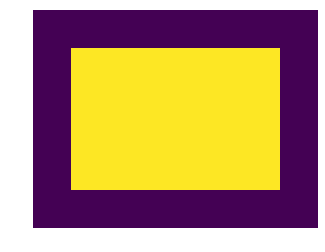

In [14]:
#show plane edge
test = np.zeros((171,224), np.uint8)
l = 30
test[l:171-l,l:224-l] = 1
plt.imshow(test),plt.axis('off')
plt.show()

In [15]:
test = np.zeros((171,224), np.uint8)
l = 30
test[l:171-l,l:224-l] = 1
test2 = 

SyntaxError: invalid syntax (<ipython-input-15-8fcd9baf3772>, line 4)

In [ ]:
u, v = (2, 2)
kernal = 3
x = np.zeros((5, 5))
index = 0
for h in range(0, 5):
    for w in range(0, 5):
        x[h, w] = index
        index = index + 1
bounding_sixe = math.floor(kernal/2)
print(bounding_sixe)
y = x[(u-bounding_sixe):(u+bounding_sixe+1), (v-bounding_sixe):(v+bounding_sixe+1)]
print(x)
print(y)

print(y.size)

y = np.reshape(y, (y.size,-1))
print(y)
for i, test in enumerate(y):
    print(i, test)